## RNN SCENARIO 2 POD Microservice

In [1]:
#pip install plotly==5.1.0
#at command line execute: 
# conda activate otumba
# conda install scikit-learn scipy matplotlib
# conda install nbformat
# conda install tqdm

In [2]:
import plotly.graph_objects as go 
import numpy as np 
import pandas as pd 

In [3]:
training_filename = 'scenario02-1000000-100-2.csv'
valid_filename = 'scenario02-10000-50-2.csv'
# Data from production
#prod_filename  = 'dataset_10000_500_2.csv'
prod_filename  = 'scenario02-10000-100-2.csv'

In [4]:
train = pd.read_csv(training_filename)
valid = pd.read_csv(valid_filename)
prod = pd.read_csv(prod_filename)
train.head()

,pods,file_descriptors,receive_packets,transmit_packets,dropped_packets,cpu_usage_seconds,cpu_throttled_seconds,memory_working_bytes,memory_usage_bytes,load,date
0,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.550171
1,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.602976
2,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.659358
3,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.701646
4,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.744043


# Standardize Data

In [5]:
from sklearn.preprocessing import StandardScaler
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None):
    df['timestamp'] = pd.to_datetime(df['date'])
    df['stand_value'] = df['memory_working_bytes']
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

data_scaler = parse_and_standardize(train)
parse_and_standardize(valid, data_scaler)

parse_and_standardize(prod, data_scaler)

StandardScaler()

In [6]:
#layout = dict(xaxis=dict(title='Timestamp'), yaxis=dict(title='memory_working_bytes')) 
#fig = go.Figure(layout=layout) 
#fig.add_trace(go.Scatter(x=train['timestamp'], y=train['memory_working_bytes'], 
#                         mode='markers', name='Train Non-anomaly',
#                         marker=dict(color='blue')))

In [7]:
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=valid['timestamp'], y=valid['memory_working_bytes'], 
#                         mode='markers', name='Valid Non-anomaly',
#                         marker=dict(color='blue')))

## LSTM Long Short-Term Memory

In [8]:
import torch 
import torch.nn as nn
import torch.optim as opt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class CPUDataset(Dataset):
    def __init__(self, data: pd.DataFrame, size: int):
        self.chunks = torch.FloatTensor(data['stand_value']).unfold(0, size, size)
        
    def __len__(self):
        return self.chunks.size(0)
    
    def __getitem__(self, i):
        x = self.chunks[i]
        return x

train_ds = CPUDataset(train, 64)
valid_ds = CPUDataset(valid, 64)
prod_ds  = CPUDataset(prod, 64)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, device):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(in_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        self.device = device
        self.init_hidden()
        
    def forward(self, x):
        out, self.hidden_state = self.lstm(
            x.view(len(x), 1, -1), self.hidden_state
        )
        self.hidden_state = tuple(
            [h.detach() for h in self.hidden_state]
        )
        out = out.view(len(x), -1)
        out = self.linear(out)
        return out
    
    def init_hidden(self):
        self.hidden_state = (
            torch.zeros((1, 1, self.hidden_size)).to(self.device),
            torch.zeros((1, 1, self.hidden_size)).to(self.device))

In [12]:
def train_model(model: LSTMModel, dataloaders: dict, optimizer: opt.Optimizer, 
                scheduler, criterion, device: torch.device, epochs: int):
    losses_data = {'train': [], 'valid': []}
    model.to(device)
    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}/{epochs-1}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.
            running_total = 0.
            
        # Here changes start
            for idx, sequence in enumerate(dataloaders[phase]):
                value = sequence
                value = value.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out = model(value.view(-1, 1))
                    loss = criterion(out.view(-1), value.view(-1))
        # Here changes end

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * out.size(0)
                running_total += out.size(0)

            epoch_loss = running_loss / running_total
            print(f'{phase.capitalize()} Loss: {epoch_loss}')
            losses_data[phase].append(epoch_loss)
    return losses_data

In [13]:
epochs = 200
#model = LSTMModel(1, 512, 1, device)
model = LSTMModel(1, 2048, 1, device)
dataloaders = {
    'train': DataLoader(train_ds, batch_size=1),
    'valid': DataLoader(valid_ds, batch_size=1)
}
optim = opt.Adam(params=model.parameters(), lr=1e-3)
sched = opt.lr_scheduler.OneCycleLR(
  optimizer=optim, max_lr=1e-3, steps_per_epoch=len(dataloaders['train']), epochs=epochs
)
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
losses = train_model(model, dataloaders, optim, sched, criterion, device, epochs)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199


  0%|          | 1/200 [00:30<1:42:06, 30.79s/it]

Train Loss: 0.4043331858761386
Valid Loss: 0.029067374167165587
Epoch 1/199


  1%|          | 2/200 [01:00<1:38:40, 29.90s/it]

Train Loss: 0.02513362361133861
Valid Loss: 0.020326074711712345
Epoch 2/199


  2%|▏         | 3/200 [01:29<1:37:17, 29.63s/it]

Train Loss: 0.017275046084259376
Valid Loss: 0.014927707778822099
Epoch 3/199


  2%|▏         | 4/200 [01:58<1:36:23, 29.51s/it]

Train Loss: 0.01308013939402256
Valid Loss: 0.009499010629951954
Epoch 4/199


  2%|▎         | 5/200 [02:28<1:35:46, 29.47s/it]

Train Loss: 0.005355778554922515
Valid Loss: 0.005020720788577039
Epoch 5/199


  3%|▎         | 6/200 [02:57<1:35:14, 29.46s/it]

Train Loss: 0.003663853504832965
Valid Loss: 0.0031640875801843193
Epoch 6/199


  4%|▎         | 7/200 [03:26<1:34:35, 29.41s/it]

Train Loss: 0.002388184639734426
Valid Loss: 0.0011302993059091801
Epoch 7/199


  4%|▍         | 8/200 [03:56<1:34:20, 29.48s/it]

Train Loss: 0.001257110616644334
Valid Loss: 0.000973284600019854
Epoch 8/199


  4%|▍         | 9/200 [04:25<1:33:45, 29.45s/it]

Train Loss: 0.0010541183839265712
Valid Loss: 0.0010154337630540664
Epoch 9/199


  5%|▌         | 10/200 [04:55<1:33:13, 29.44s/it]

Train Loss: 0.0008893962733628691
Valid Loss: 0.00045599357586719895
Epoch 10/199


  6%|▌         | 11/200 [05:24<1:32:42, 29.43s/it]

Train Loss: 0.0011099906656289913
Valid Loss: 0.0006710695244172322
Epoch 11/199


  6%|▌         | 12/200 [05:54<1:32:11, 29.42s/it]

Train Loss: 0.0007280187320874144
Valid Loss: 3.2553620842788534e-05
Epoch 12/199


  6%|▋         | 13/200 [06:23<1:31:34, 29.38s/it]

Train Loss: 0.0012853603131292098
Valid Loss: 0.0004819229039380194
Epoch 13/199


  7%|▋         | 14/200 [06:53<1:31:24, 29.49s/it]

Train Loss: 0.0010095015593271914
Valid Loss: 0.00014961837950977497
Epoch 14/199


  8%|▊         | 15/200 [07:22<1:30:49, 29.46s/it]

Train Loss: 0.0006272377650754563
Valid Loss: 0.0019469514289604767
Epoch 15/199


  8%|▊         | 16/200 [07:51<1:30:11, 29.41s/it]

Train Loss: 0.0006987004821785084
Valid Loss: 0.0012255973748064467
Epoch 16/199


  8%|▊         | 17/200 [08:21<1:29:51, 29.46s/it]

Train Loss: 0.0005942053525413488
Valid Loss: 0.0008579382057567793
Epoch 17/199


  9%|▉         | 18/200 [08:50<1:29:28, 29.50s/it]

Train Loss: 0.0005945713383138688
Valid Loss: 0.00016372350104835017
Epoch 18/199


 10%|▉         | 19/200 [09:20<1:29:02, 29.52s/it]

Train Loss: 0.00042770469771508183
Valid Loss: 0.00028292685081916194
Epoch 19/199


 10%|█         | 20/200 [09:50<1:28:36, 29.54s/it]

Train Loss: 0.0007488248821728744
Valid Loss: 0.0031837854112382047
Epoch 20/199


 10%|█         | 21/200 [10:19<1:27:53, 29.46s/it]

Train Loss: 0.0020866591782448423
Valid Loss: 3.82382983973782e-05
Epoch 21/199


 11%|█         | 22/200 [10:48<1:27:16, 29.42s/it]

Train Loss: 0.000340185061737079
Valid Loss: 2.412709209563348e-05
Epoch 22/199


 12%|█▏        | 23/200 [11:17<1:26:39, 29.38s/it]

Train Loss: 0.0006933974156660631
Valid Loss: 7.725410114289843e-06
Epoch 23/199


 12%|█▏        | 24/200 [11:47<1:26:05, 29.35s/it]

Train Loss: 0.00046743563724928637
Valid Loss: 1.5530438434195404e-05
Epoch 24/199


 12%|█▎        | 25/200 [12:16<1:25:32, 29.33s/it]

Train Loss: 0.0003946236117666196
Valid Loss: 1.620182553909087e-05
Epoch 25/199


 13%|█▎        | 26/200 [12:45<1:25:02, 29.33s/it]

Train Loss: 0.0002921279384064273
Valid Loss: 4.5859737513507885e-06
Epoch 26/199


 14%|█▎        | 27/200 [13:15<1:24:30, 29.31s/it]

Train Loss: 0.00017384587922528175
Valid Loss: 0.002974695189290547
Epoch 27/199


 14%|█▍        | 28/200 [13:44<1:24:00, 29.30s/it]

Train Loss: 0.0007498495124626638
Valid Loss: 2.6158744544448253e-05
Epoch 28/199


 14%|█▍        | 29/200 [14:13<1:23:38, 29.35s/it]

Train Loss: 0.0003651154954372948
Valid Loss: 3.393081997111429e-05
Epoch 29/199


 15%|█▌        | 30/200 [14:43<1:23:32, 29.48s/it]

Train Loss: 0.00017699953862139182
Valid Loss: 0.0002443480303294824
Epoch 30/199


 16%|█▌        | 31/200 [15:12<1:22:52, 29.42s/it]

Train Loss: 0.00033360648477985056
Valid Loss: 0.0011367949399365379
Epoch 31/199


 16%|█▌        | 32/200 [15:42<1:22:15, 29.38s/it]

Train Loss: 0.0006346426490458026
Valid Loss: 6.499897244793829e-05
Epoch 32/199


 16%|█▋        | 33/200 [16:11<1:21:50, 29.41s/it]

Train Loss: 0.00030488704099000257
Valid Loss: 0.00016484735793450715
Epoch 33/199


 17%|█▋        | 34/200 [16:41<1:21:30, 29.46s/it]

Train Loss: 0.000360180941100852
Valid Loss: 0.00018010199255513726
Epoch 34/199


 18%|█▊        | 35/200 [17:10<1:21:01, 29.46s/it]

Train Loss: 0.0001444294955440109
Valid Loss: 0.0009037347294257156
Epoch 35/199


 18%|█▊        | 36/200 [17:40<1:20:23, 29.41s/it]

Train Loss: 0.0002730168533089932
Valid Loss: 0.0004600615190741207
Epoch 36/199


 18%|█▊        | 37/200 [18:09<1:19:47, 29.37s/it]

Train Loss: 0.0001389667561244536
Valid Loss: 0.00035725834771125974
Epoch 37/199


 19%|█▉        | 38/200 [18:38<1:19:14, 29.35s/it]

Train Loss: 0.00024883628541207754
Valid Loss: 0.0004537069086966637
Epoch 38/199


 20%|█▉        | 39/200 [19:07<1:18:41, 29.33s/it]

Train Loss: 0.00013582052410345983
Valid Loss: 0.0018695130384003278
Epoch 39/199


 20%|██        | 40/200 [19:37<1:18:09, 29.31s/it]

Train Loss: 0.00021133572608015192
Valid Loss: 6.185411023450018e-05
Epoch 40/199


 20%|██        | 41/200 [20:06<1:17:38, 29.30s/it]

Train Loss: 0.00018077003913472657
Valid Loss: 0.00020833346830581183
Epoch 41/199


 21%|██        | 42/200 [20:35<1:17:08, 29.30s/it]

Train Loss: 0.00019734866176761176
Valid Loss: 0.00014312254227531542
Epoch 42/199


 22%|██▏       | 43/200 [21:05<1:16:38, 29.29s/it]

Train Loss: 0.00018754334959308452
Valid Loss: 9.576290150497308e-05
Epoch 43/199


 22%|██▏       | 44/200 [21:34<1:16:08, 29.29s/it]

Train Loss: 0.00022138309714741716
Valid Loss: 0.00012214752911989178
Epoch 44/199


 22%|██▎       | 45/200 [22:03<1:15:48, 29.35s/it]

Train Loss: 0.0001147647354129169
Valid Loss: 1.1519089736923758e-05
Epoch 45/199


 23%|██▎       | 46/200 [22:32<1:15:11, 29.30s/it]

Train Loss: 0.0001466881230903197
Valid Loss: 0.0001121904824685771
Epoch 46/199


 24%|██▎       | 47/200 [23:02<1:14:36, 29.26s/it]

Train Loss: 0.0001620700557026523
Valid Loss: 6.059671447035596e-06
Epoch 47/199


 24%|██▍       | 48/200 [23:31<1:14:03, 29.23s/it]

Train Loss: 0.00011573012314093177
Valid Loss: 2.6087180101187967e-05
Epoch 48/199


 24%|██▍       | 49/200 [24:00<1:13:31, 29.21s/it]

Train Loss: 0.00021953540656814203
Valid Loss: 2.406798830634216e-05
Epoch 49/199


 25%|██▌       | 50/200 [24:29<1:13:00, 29.20s/it]

Train Loss: 0.00016961092365452341
Valid Loss: 3.2680635188496254e-06
Epoch 50/199


 26%|██▌       | 51/200 [24:58<1:12:30, 29.20s/it]

Train Loss: 0.00010714486308264203
Valid Loss: 5.984996213166076e-06
Epoch 51/199


 26%|██▌       | 52/200 [25:28<1:12:25, 29.36s/it]

Train Loss: 0.00013862255781670708
Valid Loss: 8.379141413732733e-06
Epoch 52/199


 26%|██▋       | 53/200 [25:57<1:11:52, 29.34s/it]

Train Loss: 0.00015781760453818835
Valid Loss: 1.7968356619998565e-05
Epoch 53/199


 27%|██▋       | 54/200 [26:27<1:11:20, 29.32s/it]

Train Loss: 0.00014029925773199306
Valid Loss: 7.52862976176922e-06
Epoch 54/199


 28%|██▊       | 55/200 [26:56<1:10:50, 29.31s/it]

Train Loss: 0.00016554386853369338
Valid Loss: 2.41809070087941e-06
Epoch 55/199


 28%|██▊       | 56/200 [27:25<1:10:19, 29.30s/it]

Train Loss: 0.0001495647100022718
Valid Loss: 3.3531112291841836e-06
Epoch 56/199


 28%|██▊       | 57/200 [27:55<1:09:59, 29.37s/it]

Train Loss: 0.0001720983183175179
Valid Loss: 2.067493411012882e-06
Epoch 57/199


 29%|██▉       | 58/200 [28:24<1:09:26, 29.34s/it]

Train Loss: 0.00012431975588470375
Valid Loss: 9.781524689904992e-06
Epoch 58/199


 30%|██▉       | 59/200 [28:53<1:08:55, 29.33s/it]

Train Loss: 0.00011710751210150602
Valid Loss: 5.242124245796731e-06
Epoch 59/199


 30%|███       | 60/200 [29:23<1:08:24, 29.32s/it]

Train Loss: 0.00017154695960215253
Valid Loss: 3.1454728051422923e-06
Epoch 60/199


 30%|███       | 61/200 [29:52<1:08:16, 29.47s/it]

Train Loss: 0.0001226395651516935
Valid Loss: 2.936164366116957e-06
Epoch 61/199


 31%|███       | 62/200 [30:23<1:08:16, 29.68s/it]

Train Loss: 0.000135673903423693
Valid Loss: 2.719074294483497e-06
Epoch 62/199


 32%|███▏      | 63/200 [30:54<1:08:54, 30.18s/it]

Train Loss: 0.00011634250583416864
Valid Loss: 6.25463020956626e-06
Epoch 63/199


 32%|███▏      | 64/200 [31:25<1:09:14, 30.55s/it]

Train Loss: 0.00011078473856898058
Valid Loss: 3.3995453268939206e-06
Epoch 64/199


 32%|███▎      | 65/200 [31:57<1:09:16, 30.79s/it]

Train Loss: 0.00011217523044882707
Valid Loss: 3.0314306473298658e-06
Epoch 65/199


 33%|███▎      | 66/200 [32:28<1:09:12, 30.99s/it]

Train Loss: 0.00010498222425292215
Valid Loss: 2.991068255044281e-06
Epoch 66/199


 34%|███▎      | 67/200 [33:00<1:08:56, 31.10s/it]

Train Loss: 8.188868885821228e-05
Valid Loss: 3.0243250941046947e-06
Epoch 67/199


 34%|███▍      | 68/200 [33:30<1:08:19, 31.06s/it]

Train Loss: 6.865378876681732e-05
Valid Loss: 4.609340537951669e-06
Epoch 68/199


 34%|███▍      | 69/200 [34:01<1:07:20, 30.84s/it]

Train Loss: 9.141468315085133e-05
Valid Loss: 2.6018538911947483e-06
Epoch 69/199


 35%|███▌      | 70/200 [34:31<1:06:04, 30.49s/it]

Train Loss: 7.128253719477808e-05
Valid Loss: 1.991711280473802e-06
Epoch 70/199


 36%|███▌      | 71/200 [35:01<1:05:19, 30.38s/it]

Train Loss: 6.58317142186965e-05
Valid Loss: 2.114977076774137e-06
Epoch 71/199


 36%|███▌      | 72/200 [35:31<1:04:41, 30.33s/it]

Train Loss: 5.6476812337543606e-05
Valid Loss: 3.6450028346735053e-06
Epoch 72/199


 36%|███▋      | 73/200 [36:01<1:03:53, 30.18s/it]

Train Loss: 0.0001120540745912407
Valid Loss: 2.1415498677259037e-06
Epoch 73/199


 37%|███▋      | 74/200 [36:30<1:02:56, 29.98s/it]

Train Loss: 5.4941811537282614e-05
Valid Loss: 2.4381043155179734e-06
Epoch 74/199


 38%|███▊      | 75/200 [37:00<1:02:18, 29.91s/it]

Train Loss: 8.43374806692691e-05
Valid Loss: 3.2424460414404166e-06
Epoch 75/199


 38%|███▊      | 76/200 [37:29<1:01:35, 29.80s/it]

Train Loss: 7.404330074801653e-05
Valid Loss: 3.1043355548376894e-06
Epoch 76/199


 38%|███▊      | 77/200 [37:59<1:00:46, 29.65s/it]

Train Loss: 5.6199755673949077e-05
Valid Loss: 3.691137708626359e-06
Epoch 77/199


 39%|███▉      | 78/200 [38:28<1:00:07, 29.57s/it]

Train Loss: 5.7706392902158466e-05
Valid Loss: 3.3193201066491644e-06
Epoch 78/199


 40%|███▉      | 79/200 [38:58<59:31, 29.51s/it]  

Train Loss: 5.041709882674961e-05
Valid Loss: 4.4726329113992894e-06
Epoch 79/199


 40%|████      | 80/200 [39:27<58:57, 29.48s/it]

Train Loss: 6.952788825196284e-05
Valid Loss: 6.373992586564522e-06
Epoch 80/199


 40%|████      | 81/200 [39:56<58:29, 29.50s/it]

Train Loss: 7.334985073326472e-05
Valid Loss: 7.817668659981791e-06
Epoch 81/199


 41%|████      | 82/200 [40:26<57:55, 29.45s/it]

Train Loss: 6.162969597746735e-05
Valid Loss: 8.939798947592084e-06
Epoch 82/199


 42%|████▏     | 83/200 [40:56<57:35, 29.54s/it]

Train Loss: 4.005027148830533e-05
Valid Loss: 2.0282984613524085e-05
Epoch 83/199


 42%|████▏     | 84/200 [41:25<57:05, 29.53s/it]

Train Loss: 4.741143384678805e-05
Valid Loss: 5.004624394392262e-06
Epoch 84/199


 42%|████▎     | 85/200 [41:55<56:51, 29.67s/it]

Train Loss: 5.9110960104274385e-05
Valid Loss: 2.1567586372839287e-05
Epoch 85/199


 43%|████▎     | 86/200 [42:25<56:14, 29.61s/it]

Train Loss: 5.203248263718918e-05
Valid Loss: 4.868206799203888e-06
Epoch 86/199


 44%|████▎     | 87/200 [42:54<55:43, 29.59s/it]

Train Loss: 3.6840419819577586e-05
Valid Loss: 1.730646259342653e-05
Epoch 87/199


 44%|████▍     | 88/200 [43:24<55:11, 29.57s/it]

Train Loss: 6.090782985115731e-05
Valid Loss: 1.2896389388775528e-05
Epoch 88/199


 44%|████▍     | 89/200 [43:53<54:37, 29.53s/it]

Train Loss: 7.405553216717893e-05
Valid Loss: 1.2414017906589184e-05
Epoch 89/199


 45%|████▌     | 90/200 [44:23<54:06, 29.52s/it]

Train Loss: 5.857534412590584e-05
Valid Loss: 5.738714776271081e-06
Epoch 90/199


 46%|████▌     | 91/200 [44:52<53:36, 29.51s/it]

Train Loss: 6.235452617574346e-05
Valid Loss: 2.19760024070378e-06
Epoch 91/199


 46%|████▌     | 92/200 [45:22<53:10, 29.55s/it]

Train Loss: 4.600224515261043e-05
Valid Loss: 2.265523697328068e-05
Epoch 92/199


 46%|████▋     | 93/200 [45:51<52:43, 29.56s/it]

Train Loss: 4.261339880369607e-05
Valid Loss: 2.02848383017746e-06
Epoch 93/199


 47%|████▋     | 94/200 [46:21<52:13, 29.56s/it]

Train Loss: 4.354713534631286e-05
Valid Loss: 3.7699367437328745e-05
Epoch 94/199


 48%|████▊     | 95/200 [46:50<51:39, 29.52s/it]

Train Loss: 4.1458066036115624e-05
Valid Loss: 2.3192641559636025e-06
Epoch 95/199


 48%|████▊     | 96/200 [47:20<51:15, 29.57s/it]

Train Loss: 2.967524049957297e-05
Valid Loss: 4.444809552036791e-06
Epoch 96/199


 48%|████▊     | 97/200 [47:50<50:50, 29.62s/it]

Train Loss: 5.264591578585431e-05
Valid Loss: 7.049470156061943e-06
Epoch 97/199


 49%|████▉     | 98/200 [48:20<50:49, 29.89s/it]

Train Loss: 3.5830086895089784e-05
Valid Loss: 1.1670958299094178e-05
Epoch 98/199


 50%|████▉     | 99/200 [48:51<50:43, 30.13s/it]

Train Loss: 7.263341169899302e-05
Valid Loss: 2.7385269017291387e-05
Epoch 99/199


 50%|█████     | 100/200 [49:21<50:15, 30.15s/it]

Train Loss: 2.8176495419931766e-05
Valid Loss: 1.669284500849244e-06
Epoch 100/199


 50%|█████     | 101/200 [49:51<49:37, 30.07s/it]

Train Loss: 3.561199421908002e-05
Valid Loss: 4.358081241662148e-06
Epoch 101/199


 51%|█████     | 102/200 [50:21<49:10, 30.11s/it]

Train Loss: 4.6199654009661846e-05
Valid Loss: 5.202454283497511e-06
Epoch 102/199


 52%|█████▏    | 103/200 [50:51<48:39, 30.10s/it]

Train Loss: 2.83638975597874e-05
Valid Loss: 1.0503342829386903e-05
Epoch 103/199


 52%|█████▏    | 104/200 [51:21<48:04, 30.05s/it]

Train Loss: 3.071607912923597e-05
Valid Loss: 2.5253938474634197e-05
Epoch 104/199


 52%|█████▎    | 105/200 [51:51<47:41, 30.12s/it]

Train Loss: 4.650008695170546e-05
Valid Loss: 4.377530757437853e-06
Epoch 105/199


 53%|█████▎    | 106/200 [52:21<46:52, 29.92s/it]

Train Loss: 2.5491610392177697e-05
Valid Loss: 1.23274862744438e-05
Epoch 106/199


 54%|█████▎    | 107/200 [52:51<46:23, 29.93s/it]

Train Loss: 2.6112922704923366e-05
Valid Loss: 1.221239758462746e-06
Epoch 107/199


 54%|█████▍    | 108/200 [53:20<45:39, 29.77s/it]

Train Loss: 2.708736750771807e-05
Valid Loss: 3.20269549709857e-05
Epoch 108/199


 55%|█████▍    | 109/200 [53:51<45:25, 29.95s/it]

Train Loss: 4.3030626007673785e-05
Valid Loss: 7.279428877333365e-06
Epoch 109/199


 55%|█████▌    | 110/200 [54:21<45:15, 30.17s/it]

Train Loss: 2.3045817976238034e-05
Valid Loss: 1.1659576460130796e-05
Epoch 110/199


 56%|█████▌    | 111/200 [54:51<44:33, 30.03s/it]

Train Loss: 4.219156048359671e-05
Valid Loss: 1.2074975478425034e-05
Epoch 111/199


 56%|█████▌    | 112/200 [55:20<43:45, 29.84s/it]

Train Loss: 3.848956110615943e-05
Valid Loss: 5.7322615897906613e-05
Epoch 112/199


 56%|█████▋    | 113/200 [55:51<43:30, 30.00s/it]

Train Loss: 3.098611402931493e-05
Valid Loss: 1.6904189059070112e-05
Epoch 113/199


 57%|█████▋    | 114/200 [56:20<42:48, 29.87s/it]

Train Loss: 6.572025898918246e-05
Valid Loss: 1.683605749544118e-06
Epoch 114/199


 57%|█████▊    | 115/200 [56:50<42:10, 29.77s/it]

Train Loss: 2.0527697116793204e-05
Valid Loss: 6.352844008818335e-06
Epoch 115/199


 58%|█████▊    | 116/200 [57:20<41:41, 29.79s/it]

Train Loss: 1.8613007453657398e-05
Valid Loss: 7.750952980651554e-06
Epoch 116/199


 58%|█████▊    | 117/200 [57:49<41:10, 29.76s/it]

Train Loss: 1.7990076931584647e-05
Valid Loss: 5.967526158201508e-05
Epoch 117/199


 59%|█████▉    | 118/200 [58:19<40:44, 29.82s/it]

Train Loss: 1.7241655919720864e-05
Valid Loss: 1.2179919005055645e-05
Epoch 118/199


 60%|█████▉    | 119/200 [58:49<40:21, 29.90s/it]

Train Loss: 2.8180224828895923e-05
Valid Loss: 1.0746543823967971e-05
Epoch 119/199


 60%|██████    | 120/200 [59:20<39:58, 29.99s/it]

Train Loss: 3.167431609562189e-05
Valid Loss: 3.037049113377829e-05
Epoch 120/199


 60%|██████    | 121/200 [59:52<40:15, 30.57s/it]

Train Loss: 4.67948085817904e-05
Valid Loss: 1.009705739209364e-06
Epoch 121/199


 61%|██████    | 122/200 [1:00:22<39:30, 30.40s/it]

Train Loss: 2.5802207229061928e-05
Valid Loss: 2.4450188123280115e-05
Epoch 122/199


 62%|██████▏   | 123/200 [1:00:52<38:59, 30.38s/it]

Train Loss: 5.315734125055172e-05
Valid Loss: 1.0782091384799384e-06
Epoch 123/199


 62%|██████▏   | 124/200 [1:01:22<38:26, 30.34s/it]

Train Loss: 2.8497201766796476e-05
Valid Loss: 7.308186431893253e-06
Epoch 124/199


 62%|██████▎   | 125/200 [1:01:52<37:43, 30.18s/it]

Train Loss: 5.3444614604919745e-05
Valid Loss: 9.978305440329547e-07
Epoch 125/199


 63%|██████▎   | 126/200 [1:02:22<37:16, 30.23s/it]

Train Loss: 2.419522382725571e-05
Valid Loss: 8.146626977837254e-06
Epoch 126/199


 64%|██████▎   | 127/200 [1:02:52<36:41, 30.16s/it]

Train Loss: 5.1353784475186235e-05
Valid Loss: 1.092029496671135e-06
Epoch 127/199


 64%|██████▍   | 128/200 [1:03:22<36:06, 30.08s/it]

Train Loss: 2.1300486368068933e-05
Valid Loss: 1.0785162008427765e-05
Epoch 128/199


 64%|██████▍   | 129/200 [1:03:52<35:32, 30.03s/it]

Train Loss: 4.573124196011374e-05
Valid Loss: 1.2496005581397185e-06
Epoch 129/199


 65%|██████▌   | 130/200 [1:04:23<35:12, 30.19s/it]

Train Loss: 1.8026067437134754e-05
Valid Loss: 1.8319530324463684e-05
Epoch 130/199


 66%|██████▌   | 131/200 [1:04:53<34:47, 30.26s/it]

Train Loss: 3.677378329781815e-05
Valid Loss: 2.688389461015715e-06
Epoch 131/199


 66%|██████▌   | 132/200 [1:05:23<34:16, 30.25s/it]

Train Loss: 8.787953763194711e-06
Valid Loss: 5.805360576362416e-05
Epoch 132/199


 66%|██████▋   | 133/200 [1:05:54<33:47, 30.27s/it]

Train Loss: 1.759790669747086e-05
Valid Loss: 9.375742914739606e-07
Epoch 133/199


 67%|██████▋   | 134/200 [1:06:24<33:25, 30.39s/it]

Train Loss: 2.34830374345125e-05
Valid Loss: 2.669347575740793e-06
Epoch 134/199


 68%|██████▊   | 135/200 [1:06:55<32:59, 30.45s/it]

Train Loss: 1.7010968188357057e-05
Valid Loss: 2.7752251009007167e-06
Epoch 135/199


 68%|██████▊   | 136/200 [1:07:25<32:30, 30.48s/it]

Train Loss: 2.6446079807195937e-05
Valid Loss: 1.1675650780164557e-06
Epoch 136/199


 68%|██████▊   | 137/200 [1:07:56<32:04, 30.55s/it]

Train Loss: 6.233056460289834e-06
Valid Loss: 8.654623505728004e-06
Epoch 137/199


 69%|██████▉   | 138/200 [1:08:26<31:23, 30.38s/it]

Train Loss: 2.8295177650190344e-05
Valid Loss: 6.442940509998607e-07
Epoch 138/199


 70%|██████▉   | 139/200 [1:08:56<30:47, 30.29s/it]

Train Loss: 2.3503169204100792e-05
Valid Loss: 1.0545408439810444e-06
Epoch 139/199


 70%|███████   | 140/200 [1:09:27<30:22, 30.37s/it]

Train Loss: 3.7246021361688814e-05
Valid Loss: 8.641358965531611e-07
Epoch 140/199


 70%|███████   | 141/200 [1:09:56<29:40, 30.19s/it]

Train Loss: 1.4329868964489472e-05
Valid Loss: 1.0704979960252103e-06
Epoch 141/199


 71%|███████   | 142/200 [1:10:27<29:16, 30.28s/it]

Train Loss: 3.4909850504374685e-05
Valid Loss: 8.926372793942911e-07
Epoch 142/199


 72%|███████▏  | 143/200 [1:10:57<28:45, 30.27s/it]

Train Loss: 1.3492257991643374e-05
Valid Loss: 9.237376085634099e-07
Epoch 143/199


 72%|███████▏  | 144/200 [1:11:27<28:03, 30.06s/it]

Train Loss: 1.3952768988483533e-05
Valid Loss: 7.53274047074878e-07
Epoch 144/199


 72%|███████▎  | 145/200 [1:11:57<27:31, 30.03s/it]

Train Loss: 1.8089571251932197e-05
Valid Loss: 9.727105345318826e-07
Epoch 145/199


 73%|███████▎  | 146/200 [1:12:27<27:01, 30.03s/it]

Train Loss: 2.1176142683526725e-05
Valid Loss: 8.499897626381068e-07
Epoch 146/199


 74%|███████▎  | 147/200 [1:12:57<26:26, 29.93s/it]

Train Loss: 1.3583320652356935e-05
Valid Loss: 1.100983995781592e-06
Epoch 147/199


 74%|███████▍  | 148/200 [1:13:26<25:51, 29.83s/it]

Train Loss: 1.7798335967616986e-05
Valid Loss: 8.406020255742013e-07
Epoch 148/199


 74%|███████▍  | 149/200 [1:13:56<25:17, 29.75s/it]

Train Loss: 1.0557404342588028e-05
Valid Loss: 8.500936965154844e-07
Epoch 149/199


 75%|███████▌  | 150/200 [1:14:26<24:49, 29.80s/it]

Train Loss: 1.1920480842508845e-05
Valid Loss: 8.758650721521885e-07
Epoch 150/199


 76%|███████▌  | 151/200 [1:14:56<24:23, 29.87s/it]

Train Loss: 9.231390310735186e-06
Valid Loss: 8.115076224969795e-07
Epoch 151/199


 76%|███████▌  | 152/200 [1:15:26<24:01, 30.03s/it]

Train Loss: 1.0953013105090508e-05
Valid Loss: 9.87322134652199e-07
Epoch 152/199


 76%|███████▋  | 153/200 [1:15:57<23:40, 30.22s/it]

Train Loss: 6.837379535414181e-06
Valid Loss: 7.210353751523664e-07
Epoch 153/199


 77%|███████▋  | 154/200 [1:16:27<23:09, 30.20s/it]

Train Loss: 6.721125978904387e-06
Valid Loss: 1.0821393589464736e-06
Epoch 154/199


 78%|███████▊  | 155/200 [1:16:57<22:35, 30.12s/it]

Train Loss: 7.307372231863623e-06
Valid Loss: 9.881506457531941e-07
Epoch 155/199


 78%|███████▊  | 156/200 [1:17:27<22:04, 30.10s/it]

Train Loss: 4.595462234735674e-06
Valid Loss: 1.546476312341838e-06
Epoch 156/199


 78%|███████▊  | 157/200 [1:17:57<21:28, 29.97s/it]

Train Loss: 7.797978243146026e-06
Valid Loss: 6.723140586473164e-07
Epoch 157/199


 79%|███████▉  | 158/200 [1:18:26<20:55, 29.89s/it]

Train Loss: 2.963386155140156e-05
Valid Loss: 7.015841403707717e-07
Epoch 158/199


 80%|███████▉  | 159/200 [1:18:57<20:36, 30.16s/it]

Train Loss: 2.6103847676836178e-06
Valid Loss: 7.21949502085246e-07
Epoch 159/199


 80%|████████  | 160/200 [1:19:29<20:23, 30.59s/it]

Train Loss: 1.6895581261256622e-05
Valid Loss: 6.668915933768663e-07
Epoch 160/199


 80%|████████  | 161/200 [1:20:00<20:02, 30.84s/it]

Train Loss: 1.240908484041298e-05
Valid Loss: 7.964503520189023e-07
Epoch 161/199


 81%|████████  | 162/200 [1:20:32<19:41, 31.09s/it]

Train Loss: 1.1748259894085753e-05
Valid Loss: 8.83900863105477e-07
Epoch 162/199


 82%|████████▏ | 163/200 [1:21:03<19:07, 31.02s/it]

Train Loss: 1.4313300476121349e-05
Valid Loss: 7.50342074695709e-07
Epoch 163/199


 82%|████████▏ | 164/200 [1:21:32<18:17, 30.50s/it]

Train Loss: 6.642766668622648e-06
Valid Loss: 7.846393980262942e-07
Epoch 164/199


 82%|████████▎ | 165/200 [1:22:01<17:34, 30.13s/it]

Train Loss: 1.2403808397186984e-06
Valid Loss: 8.625245868643105e-07
Epoch 165/199


 83%|████████▎ | 166/200 [1:22:30<16:56, 29.89s/it]

Train Loss: 7.820912532196741e-06
Valid Loss: 7.784512447983616e-07
Epoch 166/199


 84%|████████▎ | 167/200 [1:23:00<16:20, 29.71s/it]

Train Loss: 1.6590489106748151e-06
Valid Loss: 6.37686186268281e-07
Epoch 167/199


 84%|████████▍ | 168/200 [1:23:29<15:46, 29.58s/it]

Train Loss: 5.712445975004109e-06
Valid Loss: 5.964725252129353e-07
Epoch 168/199


 84%|████████▍ | 169/200 [1:23:58<15:14, 29.49s/it]

Train Loss: 7.46584788900743e-06
Valid Loss: 5.676735069317016e-07
Epoch 169/199


 85%|████████▌ | 170/200 [1:24:28<14:42, 29.43s/it]

Train Loss: 4.740881530630659e-06
Valid Loss: 6.092492275757065e-07
Epoch 170/199


 86%|████████▌ | 171/200 [1:24:57<14:12, 29.39s/it]

Train Loss: 2.3237868755475645e-06
Valid Loss: 5.671551114464332e-07
Epoch 171/199


 86%|████████▌ | 172/200 [1:25:26<13:42, 29.36s/it]

Train Loss: 2.9564639632811296e-06
Valid Loss: 6.927341067759179e-07
Epoch 172/199


 86%|████████▋ | 173/200 [1:25:56<13:16, 29.50s/it]

Train Loss: 5.934337580612878e-07
Valid Loss: 1.046545865587437e-06
Epoch 173/199


 87%|████████▋ | 174/200 [1:26:27<12:57, 29.92s/it]

Train Loss: 3.275118939641558e-06
Valid Loss: 7.595601780557055e-07
Epoch 174/199


 88%|████████▊ | 175/200 [1:26:58<12:34, 30.19s/it]

Train Loss: 1.447242641660377e-06
Valid Loss: 6.012493898310822e-07
Epoch 175/199


 88%|████████▊ | 176/200 [1:27:29<12:13, 30.57s/it]

Train Loss: 1.6324364228106192e-06
Valid Loss: 7.11254981768304e-07
Epoch 176/199


 88%|████████▊ | 177/200 [1:28:01<11:48, 30.82s/it]

Train Loss: 1.4560788651344072e-06
Valid Loss: 7.161131035461819e-07
Epoch 177/199


 89%|████████▉ | 178/200 [1:28:32<11:21, 30.99s/it]

Train Loss: 2.133966061032623e-06
Valid Loss: 5.144307978964337e-07
Epoch 178/199


 90%|████████▉ | 179/200 [1:29:03<10:53, 31.13s/it]

Train Loss: 1.1162181213072104e-06
Valid Loss: 5.955018177620072e-07
Epoch 179/199


 90%|█████████ | 180/200 [1:29:34<10:20, 31.05s/it]

Train Loss: 7.843191581826185e-07
Valid Loss: 7.361696441015348e-07
Epoch 180/199


 90%|█████████ | 181/200 [1:30:06<09:52, 31.20s/it]

Train Loss: 8.696226067853974e-07
Valid Loss: 5.645067859510229e-07
Epoch 181/199


 91%|█████████ | 182/200 [1:30:37<09:23, 31.29s/it]

Train Loss: 9.269959742487828e-07
Valid Loss: 5.109180766079849e-07
Epoch 182/199


 92%|█████████▏| 183/200 [1:31:09<08:52, 31.31s/it]

Train Loss: 1.1941235183627979e-06
Valid Loss: 5.022215095859142e-07
Epoch 183/199


 92%|█████████▏| 184/200 [1:31:40<08:22, 31.40s/it]

Train Loss: 7.022546041111035e-07
Valid Loss: 4.93079234331617e-07
Epoch 184/199


 92%|█████████▎| 185/200 [1:32:12<07:52, 31.49s/it]

Train Loss: 7.494289244820622e-07
Valid Loss: 4.948707440023879e-07
Epoch 185/199


 93%|█████████▎| 186/200 [1:32:43<07:20, 31.48s/it]

Train Loss: 4.11067367642538e-07
Valid Loss: 4.860834406729606e-07
Epoch 186/199


 94%|█████████▎| 187/200 [1:33:15<06:49, 31.48s/it]

Train Loss: 4.981949387971225e-07
Valid Loss: 4.861170828413768e-07
Epoch 187/199


 94%|█████████▍| 188/200 [1:33:46<06:18, 31.51s/it]

Train Loss: 2.3549975173773294e-07
Valid Loss: 4.896121968808334e-07
Epoch 188/199


 94%|█████████▍| 189/200 [1:34:18<05:47, 31.56s/it]

Train Loss: 2.875978481809579e-07
Valid Loss: 4.784762747281743e-07
Epoch 189/199


 95%|█████████▌| 190/200 [1:34:50<05:16, 31.64s/it]

Train Loss: 2.2859582203521953e-07
Valid Loss: 4.7213820053571e-07
Epoch 190/199


 96%|█████████▌| 191/200 [1:35:22<04:44, 31.66s/it]

Train Loss: 1.86422668510863e-07
Valid Loss: 4.6868858356268514e-07
Epoch 191/199


 96%|█████████▌| 192/200 [1:35:53<04:13, 31.67s/it]

Train Loss: 1.6653872752666872e-07
Valid Loss: 4.61434726872767e-07
Epoch 192/199


 96%|█████████▋| 193/200 [1:36:25<03:41, 31.68s/it]

Train Loss: 1.5393014329315698e-07
Valid Loss: 4.529256477171982e-07
Epoch 193/199


 97%|█████████▋| 194/200 [1:36:57<03:09, 31.66s/it]

Train Loss: 1.4784769361857415e-07
Valid Loss: 4.50513410069472e-07
Epoch 194/199


 98%|█████████▊| 195/200 [1:37:29<02:38, 31.72s/it]

Train Loss: 1.4969884566933424e-07
Valid Loss: 4.490207915962076e-07
Epoch 195/199


 98%|█████████▊| 196/200 [1:38:00<02:06, 31.61s/it]

Train Loss: 1.4555442842539291e-07
Valid Loss: 4.4887882236618483e-07
Epoch 196/199


 98%|█████████▊| 197/200 [1:38:32<01:34, 31.62s/it]

Train Loss: 1.4101008137187496e-07
Valid Loss: 4.5441617300769265e-07
Epoch 197/199


 99%|█████████▉| 198/200 [1:39:03<01:03, 31.60s/it]

Train Loss: 1.362027133632261e-07
Valid Loss: 4.599284008881861e-07
Epoch 198/199


100%|█████████▉| 199/200 [1:39:35<00:31, 31.59s/it]

Train Loss: 1.3400516682400224e-07
Valid Loss: 4.5552073846266694e-07
Epoch 199/199


100%|██████████| 200/200 [1:40:06<00:00, 30.03s/it]

Train Loss: 1.3332631050290016e-07
Valid Loss: 4.547103662488894e-07


In [15]:
train_values = train['stand_value'].values.astype(np.float32).flatten()
valid_values = valid['stand_value'].values.astype(np.float32).flatten()
prod_values  = prod['stand_value'].values.astype(np.float32).flatten()

# Evaluation mode

In [16]:
model.eval()

LSTMModel(
  (lstm): LSTM(1, 2048)
  (linear): Linear(in_features=2048, out_features=1, bias=True)
)

In [17]:
if torch.cuda.is_available():
   model.cuda()

In [18]:
with torch.no_grad():
    res_train = model(torch.tensor(train_values).to(device))
res_train = res_train.cpu()

In [19]:
with torch.no_grad():
    res_valid = model(torch.tensor(valid_values).to(device))
res_valid = res_valid.cpu()

In [20]:
with torch.no_grad():
    res_prod = model(torch.tensor(prod_values).to(device))
res_prod = res_prod.cpu()

## Errors Calculation

In [21]:
def calculate_prediction_errors(target, predicted, criterion):
    reconstruction_errors = []
    for t, p in zip(target, predicted):
        reconstruction_errors = np.append(
            reconstruction_errors, 
            criterion(p, t).cpu().numpy().flatten()
        )
    return reconstruction_errors

train_pred_errors = calculate_prediction_errors(
    res_train.view(-1), torch.tensor(train_values).view(-1), criterion
)
valid_pred_errors = calculate_prediction_errors(
    res_valid.view(-1), torch.tensor(valid_values).view(-1), criterion
)



prod_pred_errors = calculate_prediction_errors(
    res_prod.view(-1), torch.tensor(prod_values).view(-1), criterion
)

## Dynamic Threshold

In [22]:
window = 55
std_coef= 7

train_pred_errors_windowed = pd.Series(train_pred_errors).rolling(window=window, min_periods=1)
train_dynamic_threshold = train_pred_errors_windowed.mean() + std_coef * train_pred_errors_windowed.std()

valid_pred_errors_windowed = pd.Series(valid_pred_errors).rolling(window=window, min_periods=1)
valid_dynamic_threshold = valid_pred_errors_windowed.mean() + std_coef * valid_pred_errors_windowed.std()


prod_pred_errors_windowed = pd.Series(prod_pred_errors).rolling(window=window, min_periods=1)
prod_dynamic_threshold = prod_pred_errors_windowed.mean() + std_coef * prod_pred_errors_windowed.std()

## Metric Calculation

In [23]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(
    ground_truth: pd.DataFrame, anomalies_idxs: list
    ):
    predictions = pd.DataFrame(
        index=range(len(ground_truth)), 
        columns=['anomaly_predicted']
    )
    predictions['anomaly_predicted'] = 0
    predictions.iloc[anomalies_idxs] = 1
    
    # Calculation of the confusion matrix can be done using pandas
    confusion_matrix = pd.crosstab(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        margins=True
    )
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        beta=2., 
        average='binary'
    )
    return confusion_matrix, precision, recall, f1

## Anomaly Detection

In [24]:
from typing import Union
def detect_anomalies( result: torch.Tensor, dataset: CPUDataset, threshold: Union[float, pd.Series], n_factors: int = 0):
    anomalies_idxs = []
    for i in range(len(dataset)):
        if type(threshold) == pd.Series:
            is_anomaly = (criterion(result[i], dataset[i]) > threshold[i])
        else:
            is_anomaly = (criterion(result[i], dataset[i]) > threshold)
        if is_anomaly:
            anomalies_idxs.append(i + n_factors)
    return anomalies_idxs

In [25]:
train_anomalies_idxs = detect_anomalies(res_train, torch.tensor(train_values), train_dynamic_threshold)
valid_anomalies_idxs = detect_anomalies(res_valid, torch.tensor(valid_values), valid_dynamic_threshold)

prod_anomalies_idxs  = detect_anomalies(res_prod, torch.tensor(prod_values), prod_dynamic_threshold)



/home/peter/anaconda3/envs/otumba/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [26]:
train_anomalies_idxs 
len(train_anomalies_idxs)


1173

In [27]:
valid_anomalies_idxs
len(valid_anomalies_idxs)

5

In [28]:
prod_anomalies_idxs
len(prod_anomalies_idxs)

0

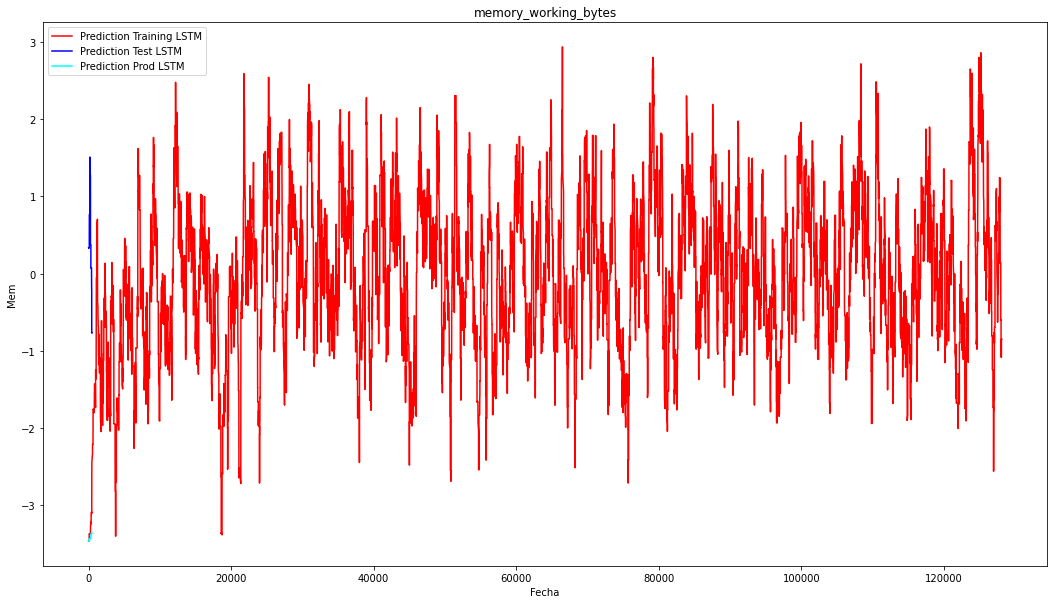

In [29]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(10)
plt.plot(res_train, color = 'red', label = 'Prediction Training LSTM')
plt.plot(res_valid, color = 'blue', label = 'Prediction Test LSTM')
plt.plot(res_prod, color = 'cyan', label = 'Prediction Prod LSTM')
plt.title("memory_working_bytes")
plt.xlabel("Fecha")
plt.ylabel("Mem")
plt.legend()
plt.show()

In [30]:
torch.save(model, "scen02-mem-210907-17-54-2048-ep200")

## 